# Imports
This cell imports standard Python libraries, reloads custom project modules (data, tools, plot) to ensure the latest changes are used, and sets default plotting parameters for Matplotlib (inline plotting, figure size, grid on axes).

In [551]:
# --- Imports standard libraries ---
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import importlib
import torch.nn.functional as F

# --- Imports project modules ---
import data
import tools
import plot
importlib.reload(data)
importlib.reload(tools)
importlib.reload(plot)

from tools import *      
from data import *
from plot import *

# --- Matplotlib settings ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


# Visualizing Selected Channels for a Specific Subject and Trial
This cell selects a subject and trial, loads the corresponding metadata and signal, chooses a subset of channels (to_plot), and visualizes them using the show_plot_simple function.

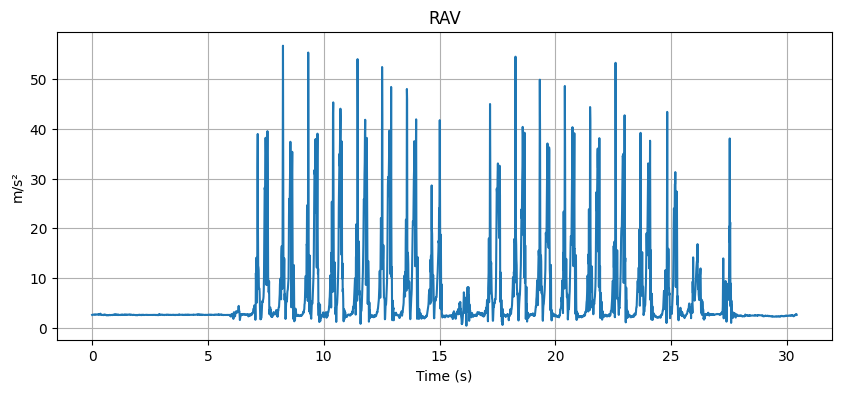

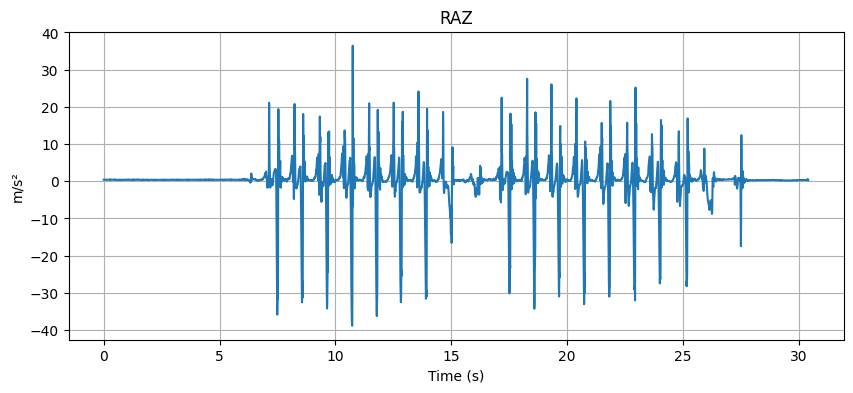

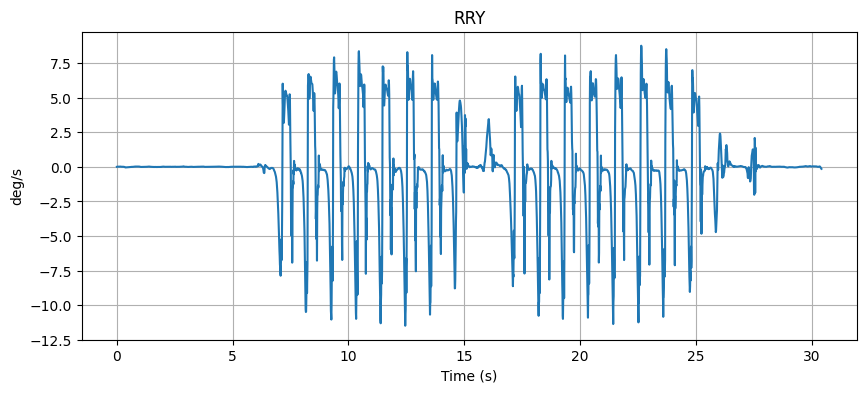

In [490]:
subject = 5
trial = 1
metadata = load_metadata(subject, trial)
signal = load_signal(subject, trial)

#to_plot = ['TOX','TAX','TAY','RAV','RAZ','RRY','LAV','LAZ','LRY']
to_plot = ['RAV','RAZ','RRY']
show_plot_simple(signal, to_plot)


# Building the Dataset and Running CDL on Selected Signals

### Constructing Data Tensor `X` and Running CDL

**Overview:**
This cell builds the input tensor $X$ for multiple subjects and selected signals, and applies **Convolutional Dictionary Learning (CDL)** to extract common atoms $\Phi$ and their sparse activations $Z$.

- **Inputs:**
  - $X \in \mathbb{R}^{S \times N \times P}$ — data tensor:
    - $S$ = number of subjects
    - $N$ = number of time samples per subject
    - $P$ = number of selected signals
  - `nb_atoms` = number of dictionary atoms $K$
  - `atoms_length` = length of each atom$ L $

- **Outputs:**
  - $\Phi \in \mathbb{R}^{K \times L \times P}$ — learned dictionary atoms
  - $Z \in \mathbb{R}^{S \times K \times (N-L+1)}$ — sparse activations
  - $A \in \mathbb{R}^{S \times K \times M}$ — **Personalized Parameters** (e.g., time warping coefficients).
---
**Steps and Details:**

- **Initialization:**
  $$\Phi, A, Z \gets \text{setInitialValues}(X, K, M, L)$$
  - Provides initial estimates for the dictionary and activations.

- **Main CDL Loop:**
    - Iteratively update activations $Z$ and atoms $\Phi$:

    1. Sparse Coding Step (CSC-L0) implemented via **`CSC_L0_DP(X, Z, Phi, lambda_)`**:
       $$
       Z \gets \text{CSC}(X, Z,\Phi): \text{for any } s \in [S], \ \arg \min_{Z_s \geq 0} \left\| x_s - \sum_{k=1}^K z_{k}^s * \phi_k \right\|_2^2 + \lambda ||Z||_0
       $$
    2. Dictionary Update (CDU) implemented via **`CDU(X, Z, Phi, lr)`**:
       $$
       \Phi \gets \text{CDU}(X, Z,\Phi): \ \arg \min_{\|\phi_k\|_2 = 1} \sum_{s=1}^S \left\| x_s - \sum_{k=1}^K z_{k}^s * \phi_k \right\|_2^2
       $$

In [491]:
subjects = list(range(1, 11))  # 10 subjects
signal_names = ['RAV','RAZ','RRY']   # select only three signals
X = build_X(subjects, signal_names, trial=1)

In [ ]:
Z,Phi,A=CDL(X,nb_atoms=2,lambda_=0.01,n_iters=10)

# Post-CDL Analysis: Visualization and Metrics

After the **CDL** (Convolutional Dictionary Learning) training phase, the function `full_plot_analysis(X, Z, Phi)` is used to evaluate and interpret the results. This cell executes a series of visualizations and metric calculations to provide a comprehensive overview of the learned dictionary ($\Phi$) and the quality of the reconstruction.

The function sequentially calls several sub-routines to analyze the outputs:

* **1. `plot_atoms(Phi)`**
    * **Description:** **Visualization of Atoms** ($\Phi$).
    * **Role:** Displays each learned atom across its different channels ($P$). It helps in understanding the **common temporal patterns** extracted from the data.

* **2. `plot_reconstruction(X, Z, Phi)`**
    * **Description:** **Signal Reconstruction**.
    * **Role:** Compares the **original signal** ($X$) with the **reconstructed signal** (calculated from $Z * \Phi$). Areas of atom activation are indicated by **colored bars**.

* **3. `plot_activations(Z)`**
    * **Description:** **Visualization of Activations** ($Z$).
    * **Role:** Displays the time series of the **sparse activation coefficients** for each atom for a given subject. It shows *when* and *where* each pattern was detected.

* **4. `print_metrics(X, Z, Phi)`**
    * **Description:** **Global Metrics**.
    * **Role:** Displays the **L2 norm** of the atoms (should be close to 1) and calculates the global **MSE** (Mean Squared Error) between the original and the reconstructed signals.

This analysis confirms that the atoms are well-formed, the reconstruction is accurate, and the activations correspond to relevant events over time.

--- Displaying Atoms (Phi) ---


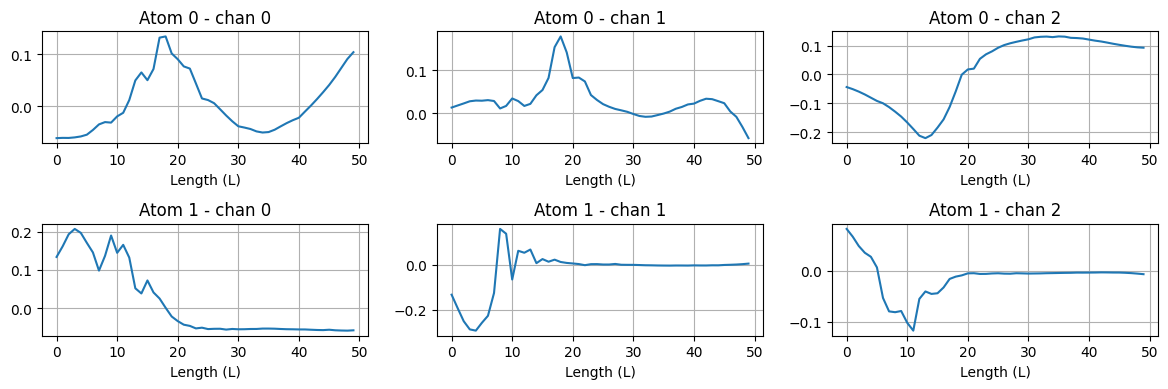


--- Reconstruction and MSE per Subject ---


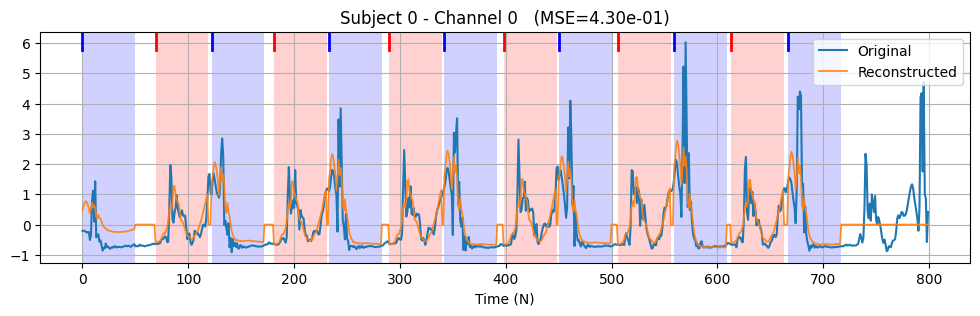

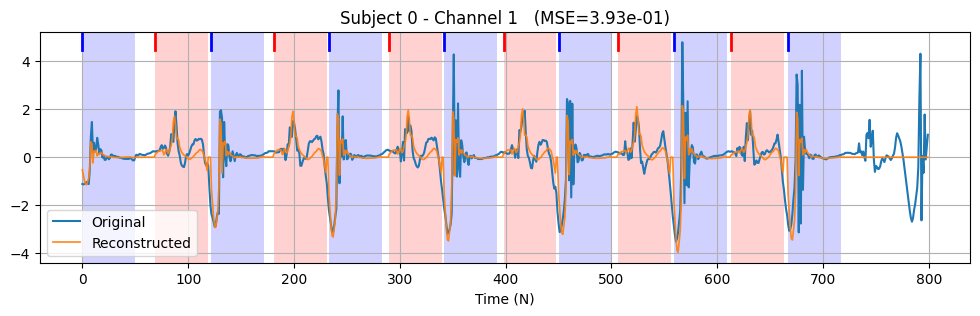

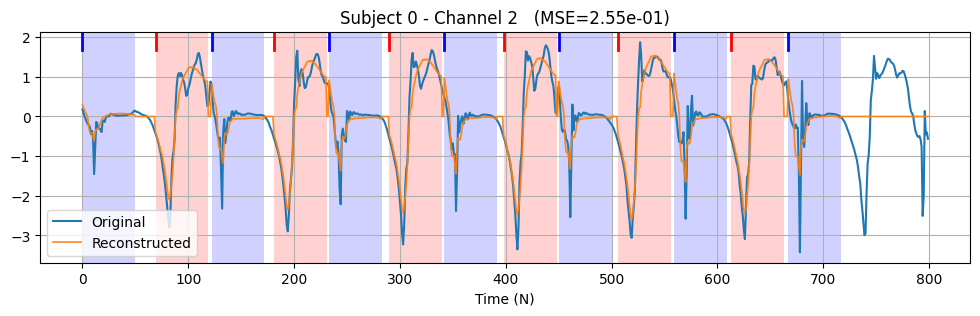


--- Displaying Activations (Z) ---


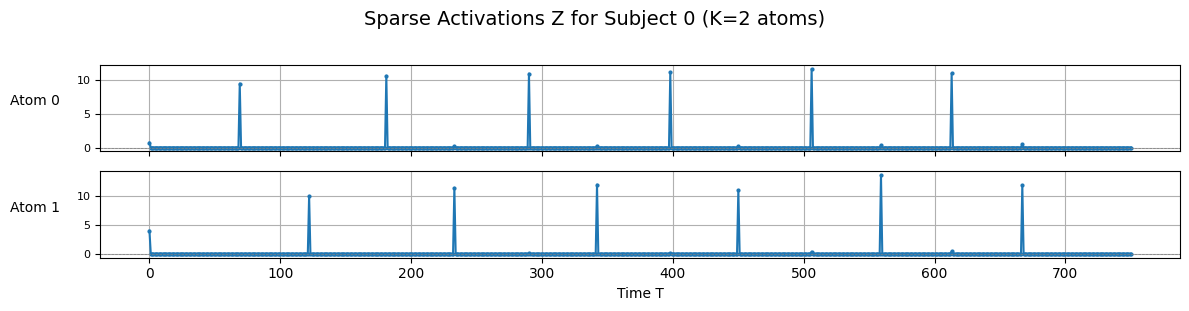


--- Global Mean Squared Error (MSE) Statistics ---
Subjects analyzed: 10
MSE Mean: 3.598200e-01
MSE Median: 3.623737e-01
MSE Minimum: 2.647618e-01
MSE Maximum: 4.491849e-01
MSE Standard Deviation: 5.374490e-02

--- Sparsity Statistics ---
Sparsity Rate (coeffs > 0): 1.3116%
Avg. number of active coefficients per subject: 19.70


In [493]:
full_plot_analysis(X,Z,Phi)

# Personalized Convolutional Dictionary Learning (PerCDL)

### Running PerCDL and Extracting Personalized Parameters

**Overview:**
This cell executes the **Personalized Convolutional Dictionary Learning (PerCDL)** algorithm. PerCDL first finds a set of common atoms $\Phi$ (standard CDL phase) and then refines the model by introducing **personalized parameters** $A$ to account for subject-specific variations (e.g., time warping).

- **Inputs:**
  - $X \in \mathbb{R}^{S \times N \times P}$ — data tensor (S subjects, N samples, P signals).
  - `nb_atoms` = number of dictionary atoms $K$.
  - `atoms_length` = length of each atom $L$.
  - $\lambda$ = sparsity regularization parameter.
  - $D, W$ = parameters defining the personalized space $A$.
  - `func` = Time Warping function
  - `nb_iters` = number of iterations of the main CDL Loop.
  - `nb_perso` = number of iterations of the Personalization Loop

- **Outputs:**
  - $A \in \mathbb{R}^{S \times K \times M}$ — **Personalized Parameters** (e.g., time warping coefficients).
  - $Z \in \mathbb{R}^{S \times K \times (N-L+1)}$ — sparse activations.
  - $\Phi \in \mathbb{R}^{K \times L \times P}$ — learned dictionary atoms.

---
**Steps and Details**

- **Initialization:**
  $$
  \Phi, Z, A \gets \text{setInitialValues}(X, K, M, L)
  $$
  - Provides initial estimates for the dictionary $\Phi$, activations $Z$, and personalized parameters $A$.

- **Main CDL Loop (Shared Dictionary Learning)**        
Run for `n_iters` iterations.
    1. Sparse Coding Step (CSC-L0-DP):
       $$Z \gets \text{CSC}(X, Z, \Phi)$$
    2. Dictionary Update (CDU):
       $$
       \Phi \gets \text{CDU}(X, Z, \Phi)
       $$

- **Personalization Loop (PerCDL Refinement)**    
Run for `n_perso` iterations.
    1. Individual Parameter Update (IPU):
       $$
       A \gets \text{IPU}(X, Z, \Phi, A, f)
       $$
       - Updates the personalized parameters $A$ (e.g., warping coefficients) for each subject based on the current $\Phi$ and $Z$.

    2. Sparse Coding Step (CSC-L0-DP):
       $$
       Z \gets \text{CSC}(X, Z, \Phi, \lambda)
       $$
       - Recomputes activations $Z$.

    3. Personalized Dictionary Update (PerCDU):
       $$
       \Phi \gets \text{PerCDU}(X, Z, \Phi, A, f)
       $$
       - Updates the dictionary $\Phi$ by accounting for the personalized parameters $A$.

In [552]:
#subjects = list(range(1, 11))  # 10 subjects
#signal_names = ['RAV','RAZ','RRY']   # select only two signals
#X = build_X(subjects, signal_names, trial=1)

In [553]:
#A,Z,Phi = PerCDL(X,2,lambda_=0.01,atoms_length=50,n_iters=10,n_perso=100)
a,z,phi = Personalization(X,A,Z,Phi,lambda_=0.01)

# Post-PerCDL Analysis: Visualization and Metrics

--- Displaying Atoms (Phi) ---


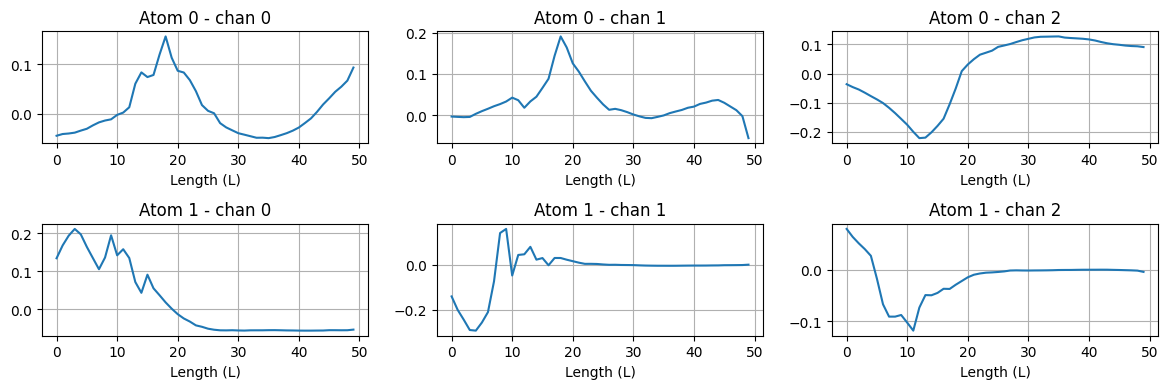


--- Reconstruction and MSE per Subject ---


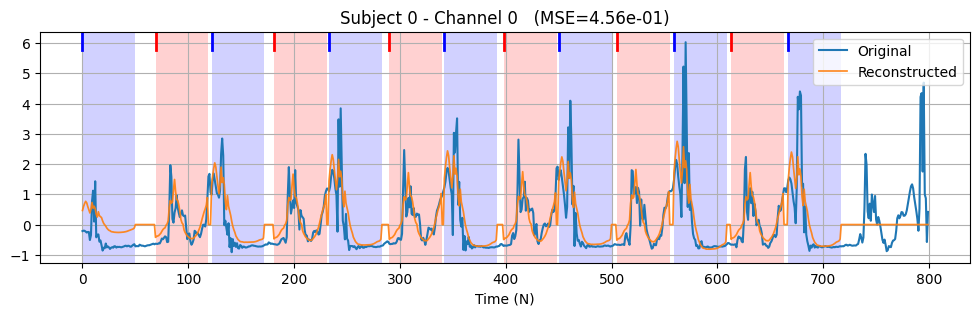

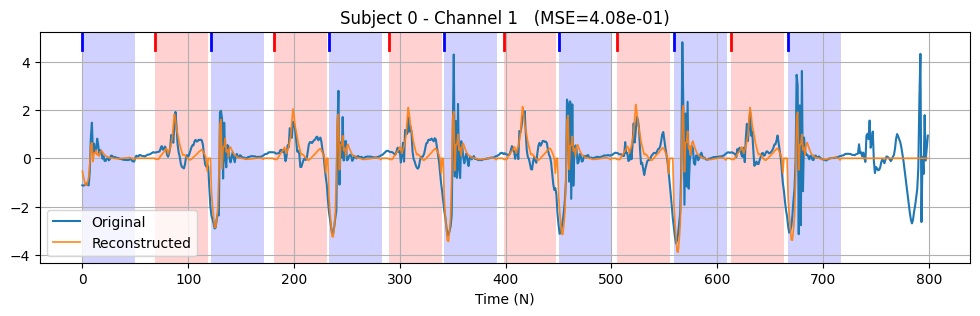

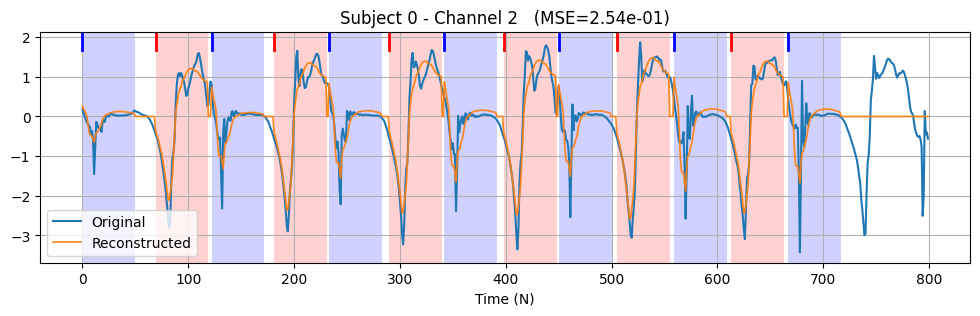


--- Displaying Activations (Z) ---


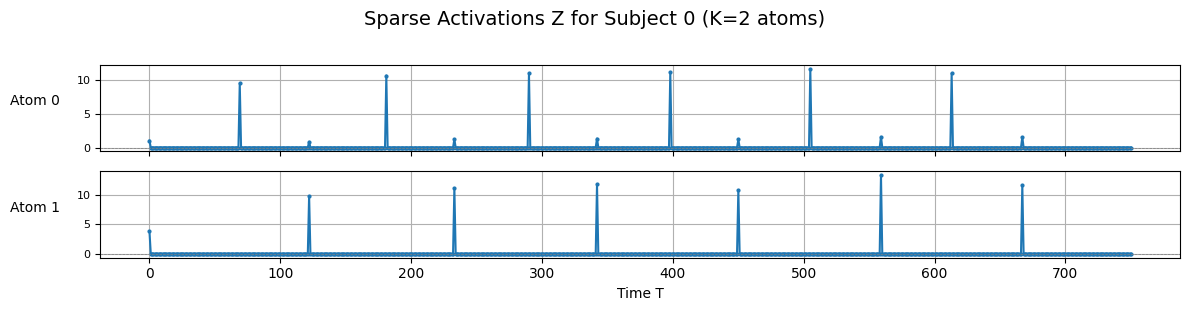


--- Global Mean Squared Error (MSE) Statistics ---
Subjects analyzed: 10
MSE Mean: 3.722629e-01
MSE Median: 3.811977e-01
MSE Minimum: 2.779955e-01
MSE Maximum: 4.603142e-01
MSE Standard Deviation: 5.556472e-02

--- Sparsity Statistics ---
Sparsity Rate (coeffs > 0): 1.1917%
Avg. number of active coefficients per subject: 17.90


In [554]:
full_plot_analysis(X,z,phi)


  FULL TIME-WARPING ANALYSIS - Subject 0 of 10

--- 4) Reconstruction Metrics (Subject 0) ---

📊 MSE per Channel (Comparison):
  Channel 0: Original=4.5576e-01, Warped=4.0464e-01
  Channel 1: Original=4.0785e-01, Warped=3.6856e-01
  Channel 2: Original=2.5427e-01, Warped=2.3375e-01

📈 Global MSE:
  Global MSE (Original Φ): 3.7263e-01
  Global MSE (Time-Warped Φ): 3.3565e-01
  Error Reduction Gain: 9.92 %

--- 1) Reconstruction Visualization (Subject 0) ---


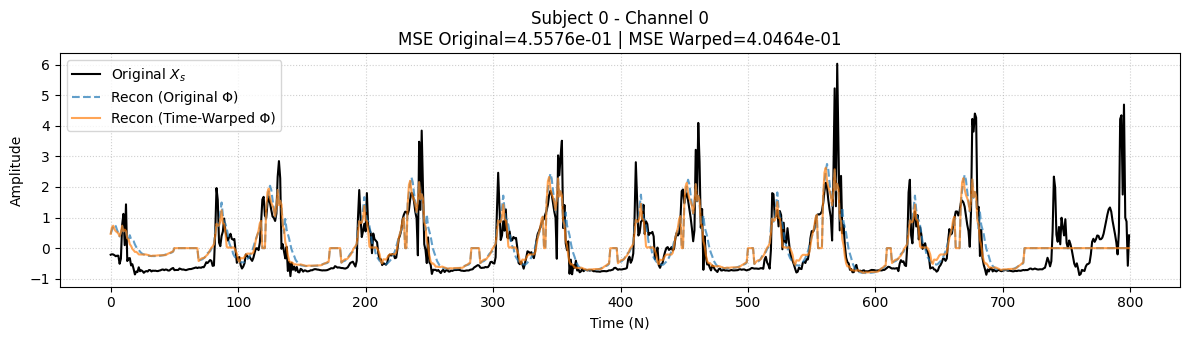

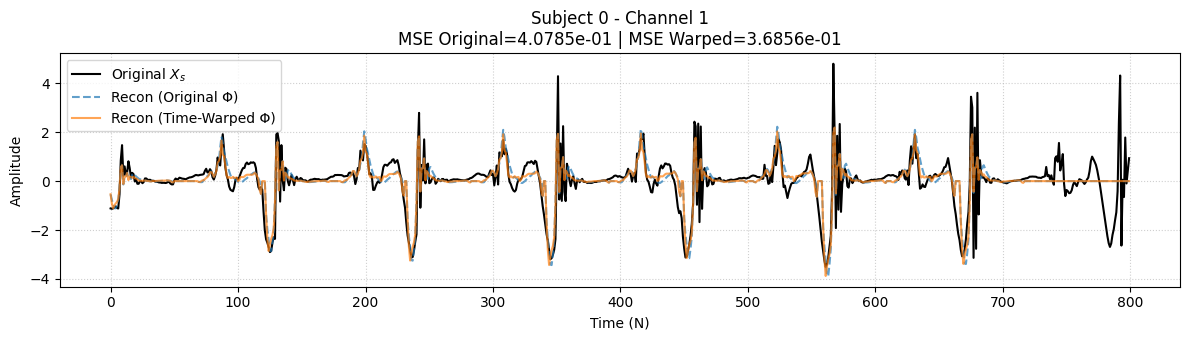

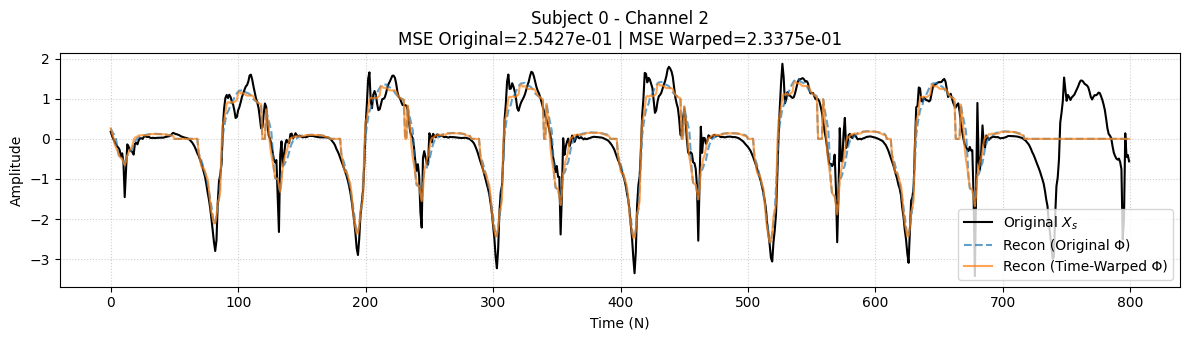


--- 2) MSE Comparison Barplot (Subject 0) ---


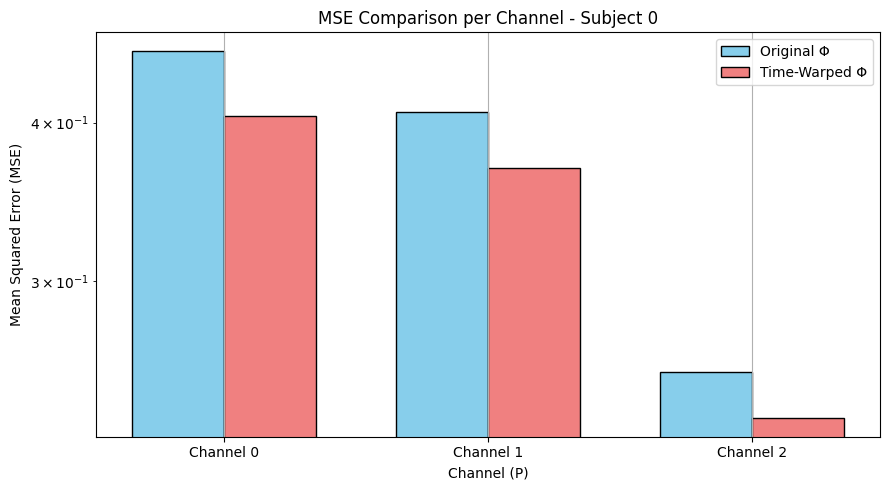


--- 3) General vs. Personalized Atoms (Subject 0) ---


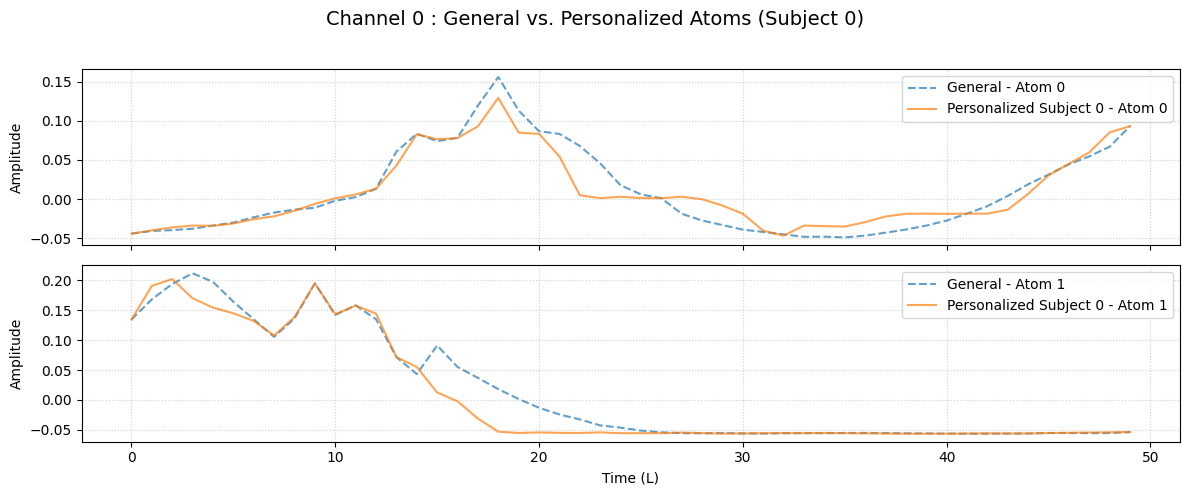

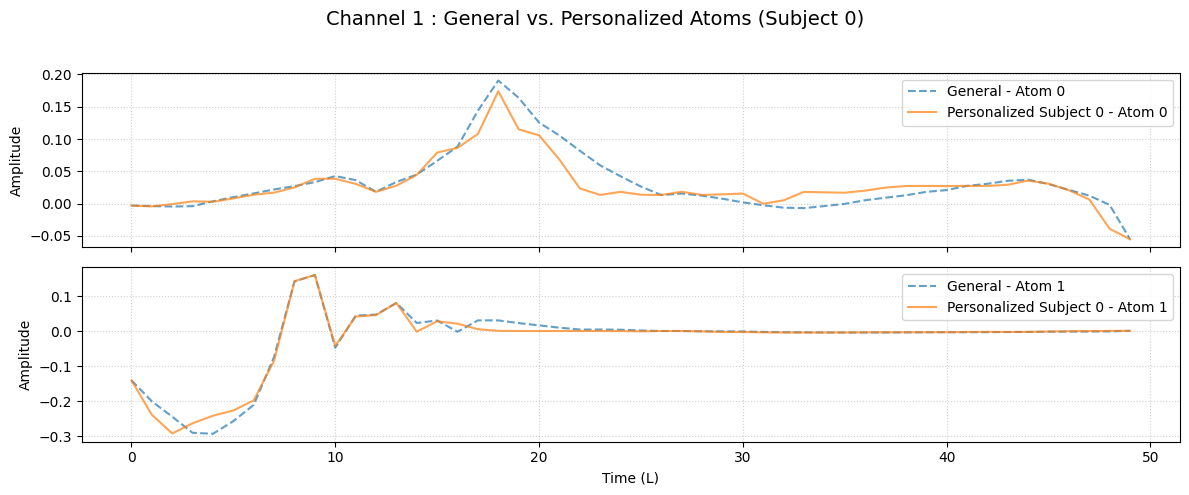

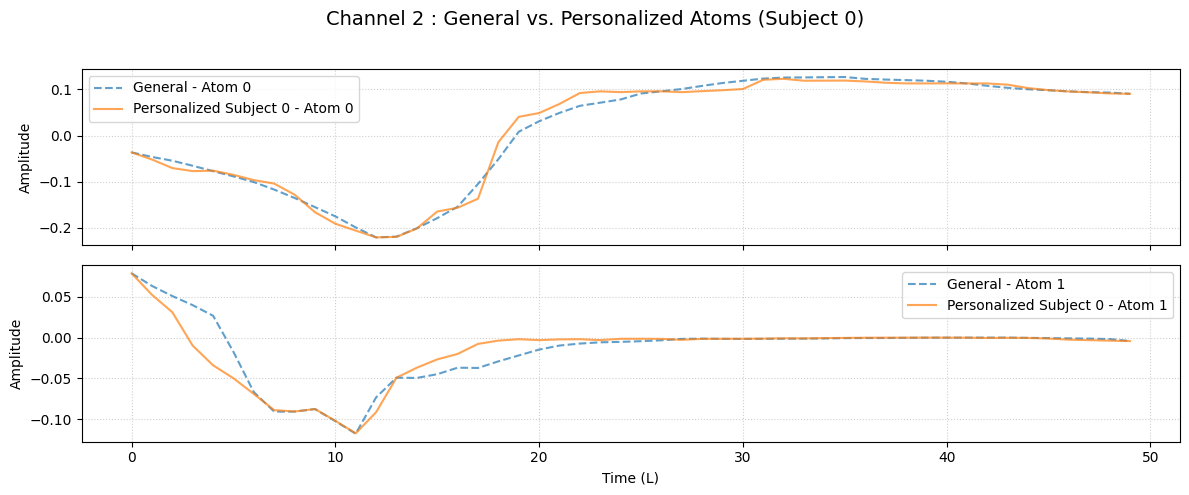

In [555]:
full_warping_analysis(X,z,phi,a)